# Kickstarter - Project Success Prediction

<a id = "top"></a>

## Index

<a href = "#import_data">Importing packages and data</a><br />
<a href = "#cleaning">Data cleaning</a><br />
<a href = "#perc_of_states">Distribution of projects by state</a><br />
<a href = "#perc_cat_state">Percentage of successful and failed projects by main category</a><br />
<a href = "#perc_proj_country">Percentage of projects by country</a><br />
<a href = "#perc_success_proj_country">Percentage of successful projects by country</a><br />
<a href = "#goal_cat_state">Goal amounts by main category and state</a><br />
<a href = "#num_success_cat">Successful projects by main category</a><br />
<a href = "#num_success_year">Successful projects by year</a><br />
<a href = "#avg_perbacker_year">Average amount contributed per backer by year</a><br />
<a href = "#num_goal_cat_50">Projects exceeding goal amount by 50% by main category</a><br />
<a href = "#avg_funding_state">Average funding period by project state</a><br />
<a href = "#avg_funding_cat">Average funding period by main category</a><br />
<a href = "#avg_funding_country">Average funding period by country</a><br />
<a href = "#goal_log">Distribution of goal and pledged amounts across successful projects</a><br />
<a href = "#funding_period_dist">Distribution of funding time period</a><br />
<a href = "#violin">Average funding period by category for failed vs successful projects</a><br />
<a href = "#wordcloud">Word cloud for successful project names, main categories and categories</a><br />
<a href = "#data_process_model">Data pre-processing for modeling</a><br />
<a href = "#correl_plot">Correlation Plot</a><br />
<a href = "#linear_reg">Linear Regression - backers and pledged amount</a><br />
<a href = "#dummy">Defining dummies for categorical variables</a><br />
<a href = "#variable_defining">Defining variables for modeling</a><br />
<a href = "#imports">Importing packages required for modeling</a><br />
<a href = "#log_reg">Logistic Regression</a><br />
<a href = "#reg_plot">Regression Plot</a><br />
<a href = "#randomforest">Random Forest</a>

<a id = "import_data"></a>

In [1]:
############################################################################################################################
#importing packages and data from the dataset file

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#for displaying the results of matplotlib inline in the notebook
%matplotlib inline
from pandas import ExcelWriter
from pandas import ExcelFile
#importing the excel file and relevant sheet
my_sheet = 'data_raw'
file_name = 'Dataset_2018.xlsx'
data = pd.read_excel(file_name, sheet_name = my_sheet)
#printing header and 1st 5 columns
print(data.head())
#printing size of data
print(data.shape)
#printing data type of columns
print(data.dtypes)

############################################################################################################################

           ID                                               name  \
0  1000002330                    The Songs of Adelaide & Abullah   
1  1000003930      Greeting From Earth: ZGAC Arts Capsule For ET   
2  1000004038                                     Where is Hank?   
3  1000007540  ToshiCapital Rekordz Needs Help to Complete Album   
4  1000011046  Community Film Project: The Art of Neighborhoo...   

         category main_category currency   deadline     goal  \
0          Poetry    Publishing      GBP 2015-10-09   1000.0   
1  Narrative Film  Film & Video      USD 2017-11-01  30000.0   
2  Narrative Film  Film & Video      USD 2013-02-26  45000.0   
3           Music         Music      USD 2012-04-16   5000.0   
4    Film & Video  Film & Video      USD 2015-08-29  19500.0   

             launched  pledged     state  backers country  usd pledged  \
0 2015-08-11 12:12:28      0.0    failed        0      GB          0.0   
1 2017-09-02 04:43:57   2421.0    failed       15      US 

<a href = "#top">Back to index</a><br />

<a id = "cleaning"></a>

In [2]:
############################################################################################################################
#cleaning the data

#trim headers
data.columns = [x.strip() for x in data.columns.tolist()]

#replace nulls with NA in the name and category columns
data["name"].fillna("NA", inplace = True)

#delete columns pledged, usd pledged and goal
data = data.drop(["pledged","usd pledged","goal"], axis = 1)

#perent difference between goal and pledged amount (pledged/goal)
data['percent']= (data['usd_pledged_real']-data['usd_goal_real'])/(data['usd_goal_real'])

#split launched col to launch date, day of the week and launch time
data["launch_date"] = pd.to_datetime(data["launched"]).apply(lambda x: x.strftime('%Y-%m-%d'))
data["launch_time"] = pd.to_datetime(data["launched"]).apply(lambda x: x.strftime('%H:%M:%S'))
data["launch_weekday"] = pd.to_datetime(data["launch_date"]).apply(lambda x: x.day_name())

data['launched'] = pd.to_datetime(data['launched'])
data['deadline'] = pd.to_datetime(data['deadline'])

data['time_diff'] = data['deadline']-data['launched']
data['time_diff'] = data['time_diff'].dt.days


data["launch_date"] = pd.to_datetime(data["launch_date"])

#remove invalid/standardize the country col based on the currency col
data.loc[data.currency == 'AUD', 'country'] = 'AU'
data.loc[data.currency == 'CAD', 'country'] = 'CA'
data.loc[data.currency == 'CHF', 'country'] = 'CH'
data.loc[data.currency == 'DKK', 'country'] = 'DK'
data.loc[data.currency == 'GBP', 'country'] = 'GB'
data.loc[data.currency == 'HKD', 'country'] = 'HK'
data.loc[data.currency == 'JPY', 'country'] = 'JP'
data.loc[data.currency == 'MXN', 'country'] = 'MX'
data.loc[data.currency == 'NOK', 'country'] = 'NO'
data.loc[data.currency == 'NZD', 'country'] = 'NZ'
data.loc[data.currency == 'SEK', 'country'] = 'SE'
data.loc[data.currency == 'SGD', 'country'] = 'SG'
data.loc[data.currency == 'USD', 'country'] = 'US'

#remove rows with invalid country names
data = data[data['country'] != 'N,0"']

#remove status=live from the data
data = data[data["state"] != "live"]

#remove invalid dates - some were 1970
data = data[data["launch_date"] >= "2000-01-01"]

print(data.dtypes)

print(data.head())
############################################################################################################################

ID                           int64
name                        object
category                    object
main_category               object
currency                    object
deadline            datetime64[ns]
launched            datetime64[ns]
state                       object
backers                      int64
country                     object
usd_pledged_real           float64
usd_goal_real              float64
Difference                 float64
percent                    float64
launch_date         datetime64[ns]
launch_time                 object
launch_weekday              object
time_diff                    int64
dtype: object
           ID                                               name  \
0  1000002330                    The Songs of Adelaide & Abullah   
1  1000003930      Greeting From Earth: ZGAC Arts Capsule For ET   
2  1000004038                                     Where is Hank?   
3  1000007540  ToshiCapital Rekordz Needs Help to Complete Album   
4  1000011046  C

<a href = "#top">Back to index</a><br />

<a id = "perc_of_states"></a>

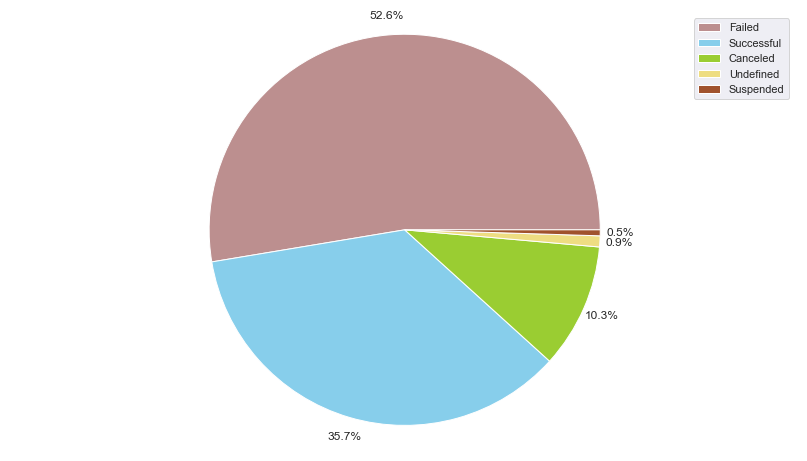

In [3]:
############################################################################################################################
#% of states

temp = data.loc[(data["state"] != "live")]
temp['state'] = temp['state'].str.capitalize()
state = round(temp["state"].value_counts() / len(temp["state"]) * 100,2)
labels = list(state.index)
values = list(state.values)
colors = ['#bc8f8f','#87ceeb','#9acd32','#eedd82','#a0522d','#696969','#f4a460']
sns.set(rc={'figure.figsize':(14,8)})
plt.pie(values, colors=colors, autopct='%1.1f%%', pctdistance = 1.1, shadow=False)
plt.axis('equal')
plt.legend(labels, loc = 1)
plt.show()


############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "perc_cat_state"></a>

[Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%')]

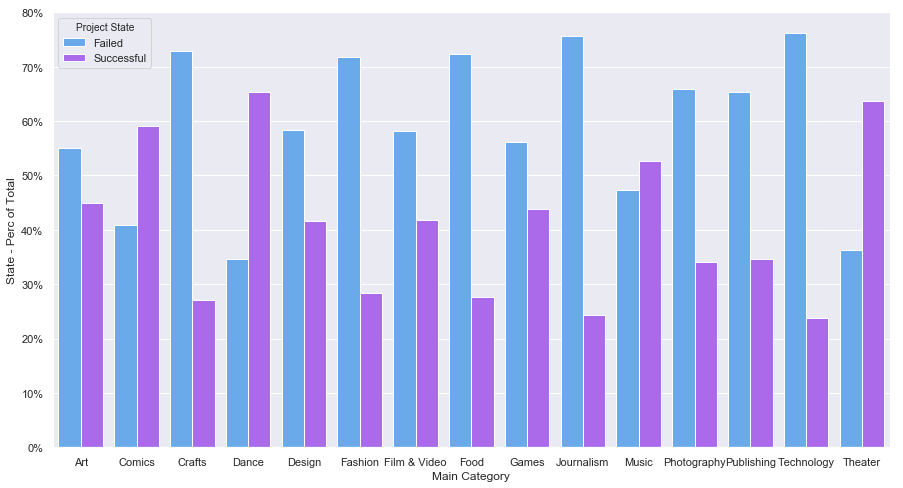

In [4]:
############################################################################################################################
# % of projects by category and state

temp = data.loc[(data["state"] == "successful") | (data["state"] == "failed")]
#group by state and category and count unique projects
temp = temp.groupby(["state","main_category"], as_index=False).agg({"ID":lambda x: x.nunique()})
temp = temp.rename({"ID":"count_state_category"}, axis = 1)
#calculate total projects to calculate perc of total
n = temp.loc[(temp["state"] == "successful") | (temp["state"] == "failed")]
n = n.groupby(["main_category"], as_index=False).agg({"count_state_category":"sum"})
n =  n.rename({"count_state_category":"count_category"}, axis = 1)

temp = pd.merge(temp,n,on="main_category",how="left")

temp["State - Perc of Total"] = (temp["count_state_category"].div(temp["count_category"]))*100

temp = temp.rename({"state":"Project State"}, axis = 1)
temp["Project State"] = temp["Project State"].str.capitalize()
temp = temp.rename({"main_category":"Main Category"}, axis = 1)

#calculcate perc of total and format
#temp["State - Perc of Total"] = temp["Project Count"].apply(lambda x: x * 100/n)
#temp["State - Perc of Total"] = pd.Series(["{0:.2f}%".format(val * 100) for val in temp["State - Perc of Total"]], index = temp.index)

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(15,8)})
ax = sns.barplot(x="Main Category",y="State - Perc of Total",hue="Project State",palette="cool",data=temp)
y_value=['{:,.0f}'.format(x) + '%' for x in ax.get_yticks()]
ax.set_yticklabels(y_value)


############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "perc_proj_country"></a>

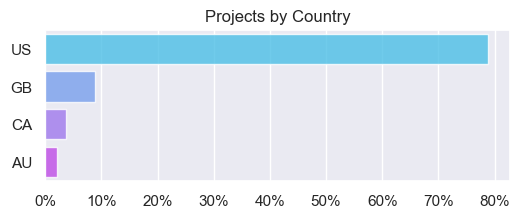

In [7]:
############################################################################################################################
#Projects by Country

temp = data.loc[(data["state"] == "successful") | (data["state"] == "failed")]
c = temp['country'].value_counts()
n = len(temp.index)
c = c*100/n
c = c.sort_values(ascending=False)
c = c.head(4)
x = c.values
y = c.index
 
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="cool", alpha=0.8)
sns.set(rc={'figure.figsize':(6,2)})
sns.set_style("darkgrid")
x_value=['{:,.0f}'.format(x) + '%' for x in ax.get_xticks()]
ax.set_xticklabels(x_value)
plt.title('Projects by Country')
plt.show()

############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "perc_success_proj_country"></a>

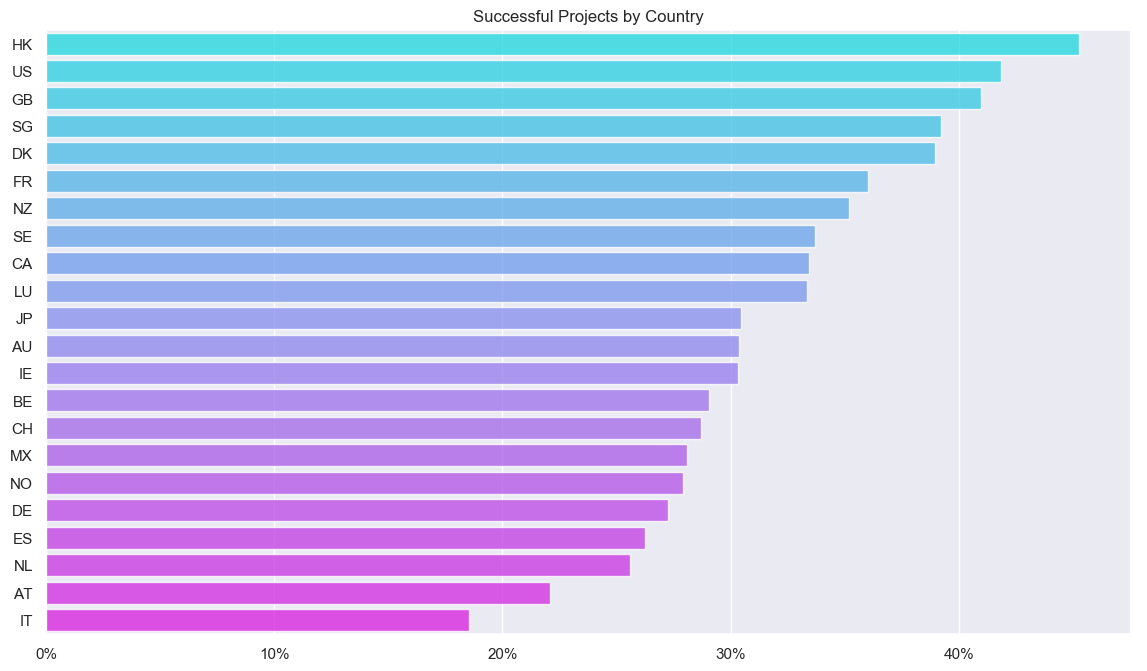

In [29]:
############################################################################################################################
#Successful projects by Country

temp = data.loc[(data["state"] == "successful") | (data["state"] == "failed")]
c = temp['country'][data['state']=='successful'].value_counts()
n = temp['country'].value_counts()
c = c*100/n
c = c.sort_values(ascending=False)
#c = c.head(4)
x = c.values
y = c.index
 
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="cool", alpha=0.8)
sns.set(rc={'figure.figsize':(12,8)})
x_value=['{:,.0f}'.format(x) + '%' for x in ax.get_xticks()]
ax.set_xticklabels(x_value)
sns.set_style("darkgrid")
plt.title('Successful Projects by Country')
plt.show()

############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "goal_cat_state"></a>

[Text(0, 0, '$0'),
 Text(0, 0, '$20,000'),
 Text(0, 0, '$40,000'),
 Text(0, 0, '$60,000'),
 Text(0, 0, '$80,000'),
 Text(0, 0, '$100,000'),
 Text(0, 0, '$120,000'),
 Text(0, 0, '$140,000')]

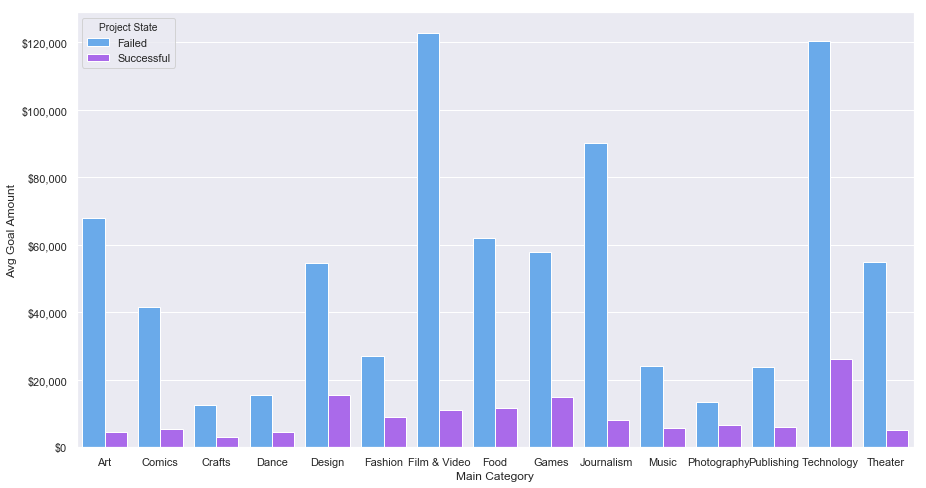

In [80]:
############################################################################################################################
# Goal amount by category and state

temp = data.loc[(data["state"] == "successful") | (data["state"] == "failed")]
#group by state and category and count unique projects
temp = temp.groupby(["state","main_category"], as_index=False).agg({"usd_goal_real":np.mean})
#rename columns
temp = temp.rename({"usd_goal_real":"Avg Goal Amount"}, axis = 1)
temp = temp.rename({"state":"Project State"}, axis = 1)
temp["Project State"] = temp["Project State"].str.capitalize()
temp = temp.rename({"main_category":"Main Category"}, axis = 1)
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(15,8)})
ax = sns.barplot(x="Main Category",y="Avg Goal Amount",hue="Project State",palette="cool",data=temp)
ticks = ax.axes.get_yticks()
ylabels = ['$' + '{:,.0f}'.format(x) for x in ticks]
ax.set_yticklabels(ylabels)

############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "num_success_cat"></a>

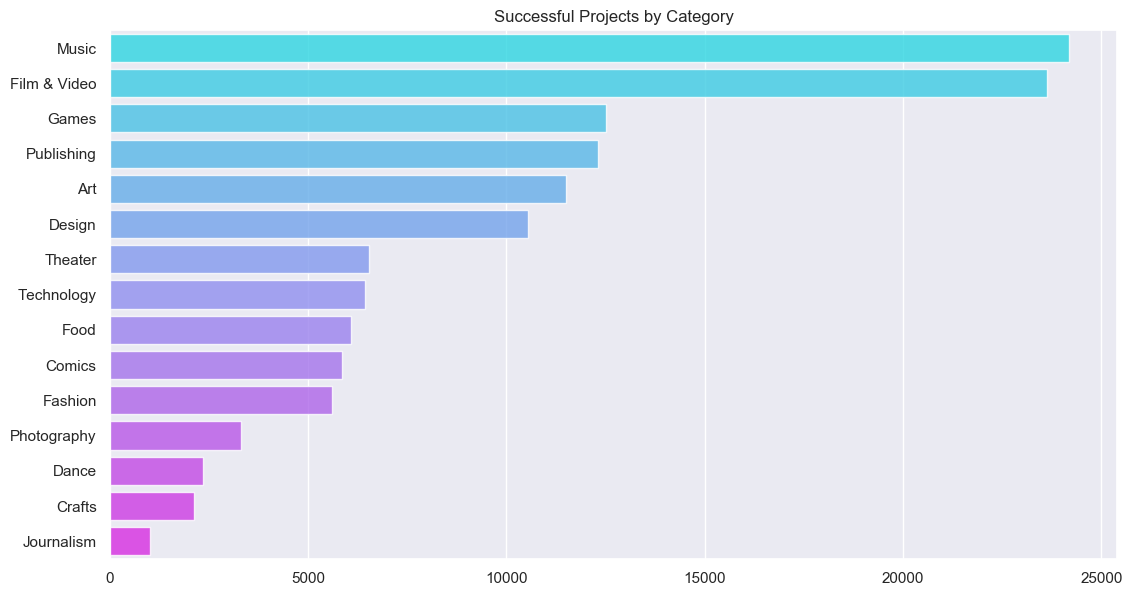

In [31]:
############################################################################################################################
#Successful projects by category

temp = data.loc[(data["state"] != "live")]
s=temp['main_category'][temp['state']=='successful'].value_counts()
 
x = s.values
y = s.index
 
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=y, x=x, orient='h', palette="cool", alpha=0.8)
sns.set(rc={'figure.figsize':(13,7)})
sns.set_style("darkgrid")
plt.title('Successful Projects by Category')
plt.show()


############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "num_success_year"></a>

C:\Users\rukmi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\rukmi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


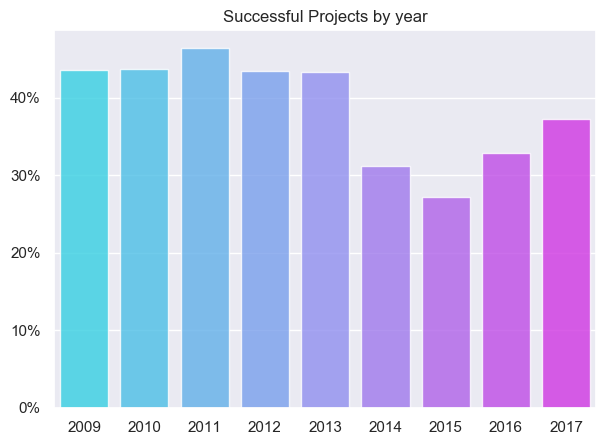

In [7]:
############################################################################################################################
#Successful projects by year

temp = data.loc[(data["launch_date"] <= "2017-12-31")]
temp['launched'] = pd.to_datetime(data['launched'])
temp['year'], temp['month'] = temp['launched'].dt.year, data['launched'].dt.month
temp.head()
a=(temp['year'][data['state']=='successful'].value_counts() * 100)/temp['year'].value_counts()
fig = plt.figure(dpi=100)
sns.set(rc={'figure.figsize':(7,5)})
ax = fig.add_subplot(111)
ax = sns.barplot(y=a.values, x=a.index, palette="cool", alpha=0.8)
 
plt.title('Successful Projects by year')
y_value=['{:,.0f}'.format(x) + '%' for x in ax.get_yticks()]
ax.set_yticklabels(y_value)
plt.show()


############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "avg_perbacker_year"></a>

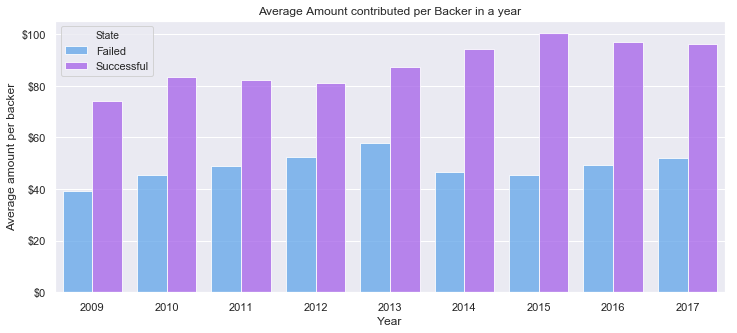

In [27]:
############################################################################################################################
#Average Amount contributed per Backer in a year

temp = data.loc[(data["launch_date"] <= "2017-12-31")]
temp = temp.loc[(temp["state"] == "successful") | (temp["state"] == "failed")]
temp['average_backer']=temp['usd_pledged_real']/temp['backers']
temp["average_backer"].fillna(0, inplace=True)
temp.replace(to_replace=[np.inf, -np.inf], value=0, inplace=True)
temp['Year'] = temp['launched'].dt.year 
temp = temp.groupby(["state","Year"], as_index=False).agg({"average_backer":np.mean})
temp = temp.rename({"average_backer":"Average amount per backer"}, axis = 1)
temp = temp.rename({"state":"State"}, axis = 1)
temp["State"] = temp["State"].str.capitalize()
 
ax = sns.barplot(y=temp["Average amount per backer"], x = temp["Year"], hue = temp["State"],palette="cool", alpha=0.8)
ticks = ax.axes.get_yticks()
ylabels = ['$' + '{:,.0f}'.format(x) for x in ticks]
ax.set_yticklabels(ylabels)
sns.set(rc={'figure.figsize':(12,5)})
sns.set_style("darkgrid")
 
plt.title('Average Amount contributed per Backer in a year')
plt.show()


############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "num_goal_cat_50"></a>

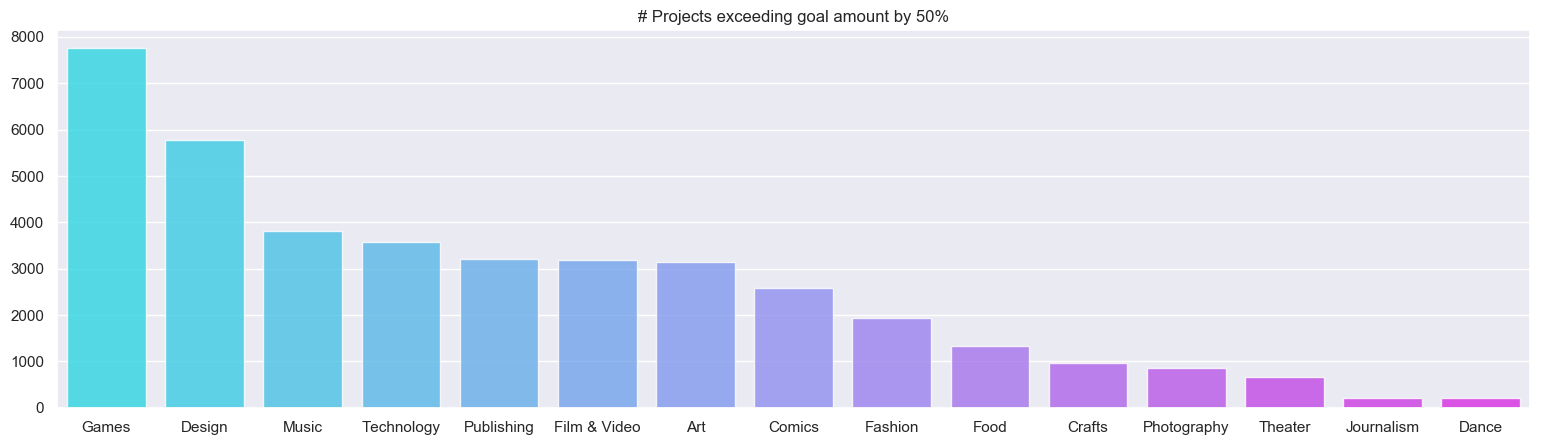

In [96]:
############################################################################################################################
## Projects exceeding goal amount by 50%

temp=data.loc[(data["state"] != "live")]
temp['exceeding_goal']=temp['usd_pledged_real']/temp['usd_goal_real']
goal_150=temp['main_category'][temp['exceeding_goal']>=1.5].value_counts()
 
 
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax = sns.barplot(y=goal_150.values, x=goal_150.index, palette="cool", alpha=0.8)
sns.set(rc={'figure.figsize':(19,5)})
sns.set_style("darkgrid")
 
plt.title('# Projects exceeding goal amount by 50%')
plt.show()
 
############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "avg_funding_state"></a>

C:\Users\rukmi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Text(0.5, 1.0, 'Average funding period by state')

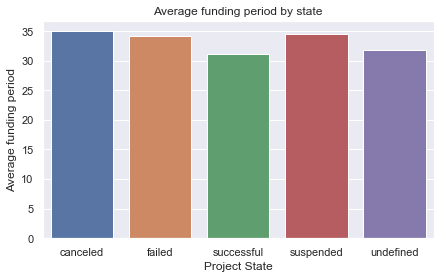

In [112]:
############################################################################################################################
#State wise Average Funding

temp=data.loc[(data["state"] != "live")]
data_state_time_diff=pd.DataFrame(temp.groupby('state')['time_diff'].agg({'Average':['mean']})).reset_index()
list(data_state_time_diff)
data_state_time_diff.columns = data_state_time_diff.columns.map(''.join)
data_state_time_diff = data_state_time_diff.rename({'Averagemean':"Average funding period"}, axis = 1)
data_state_time_diff = data_state_time_diff.rename({'state':"Project State"}, axis = 1)

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(7,4)})
ax = sns.barplot(x=data_state_time_diff["Project State"],y=data_state_time_diff['Average funding period'],data=data_state_time_diff)
plt.title('Average funding period by state')

############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "avg_funding_cat"></a>

C:\Users\rukmi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Text(0.5, 1.0, 'Average funding period by Main Category in days')

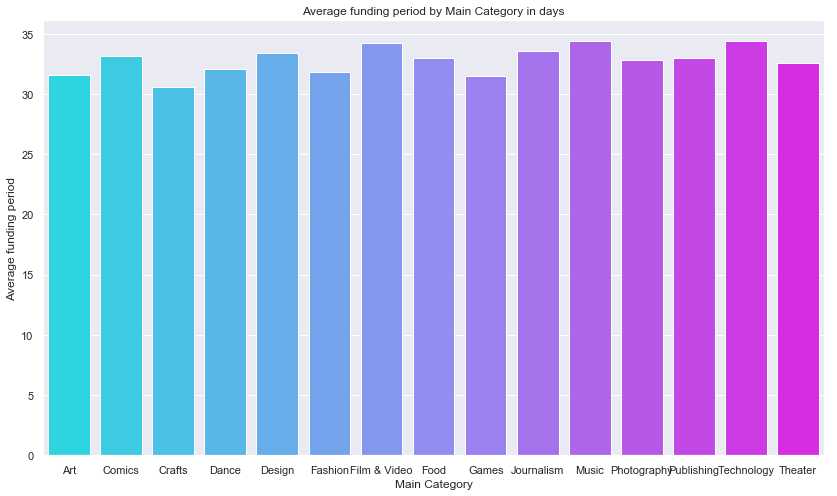

In [8]:
############################################################################################################################
#Main Category wise Average Funding

temp=data.loc[(data["state"] != "live")]
data_main_category_time_diff=pd.DataFrame(temp.groupby('main_category')['time_diff'].agg({'Average':['mean']})).reset_index()
list(data_main_category_time_diff)
data_main_category_time_diff.columns = data_main_category_time_diff.columns.map(''.join)
#print(list(data_main_category_time_diff))
data_main_category_time_diff = data_main_category_time_diff.rename({'Averagemean':"Average funding period"}, axis = 1)
data_main_category_time_diff = data_main_category_time_diff.rename({'main_category':"Main Category"}, axis = 1)
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.barplot(x=data_main_category_time_diff['Main Category'],y=data_main_category_time_diff['Average funding period'],palette="cool",data=data_main_category_time_diff)
plt.title('Average funding period by Main Category in days')

############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "avg_funding_country"></a>

C:\Users\rukmi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


Text(0.5, 1.0, 'Average funding period by country in days')

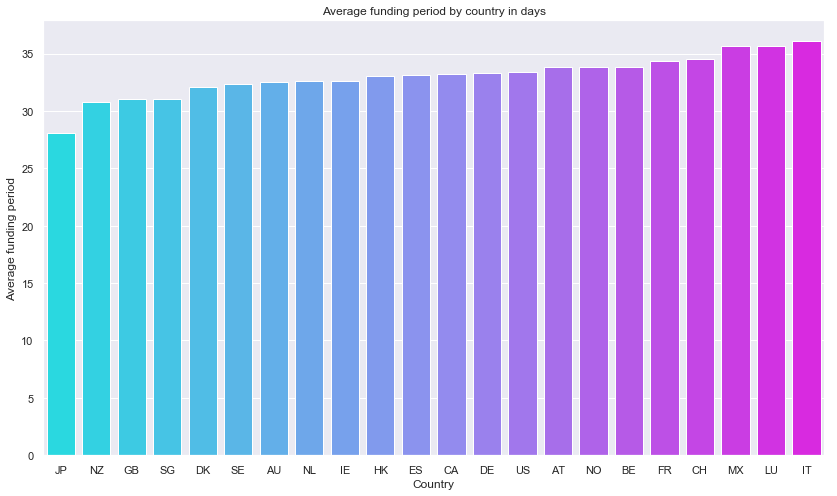

In [9]:
############################################################################################################################
#Country wise Average Funding

temp=data.loc[(data["state"] != "live")]
data_country_time_diff=pd.DataFrame(temp.groupby('country')['time_diff'].agg({'Average':['mean']})).reset_index()
list(data_country_time_diff)
data_country_time_diff.columns = data_country_time_diff.columns.map(''.join)
#print(list(data_country_time_diff))
data_country_time_diff = data_country_time_diff.sort_values(by = ["Averagemean"])
data_country_time_diff = data_country_time_diff.rename({'Averagemean':"Average funding period"}, axis = 1)
data_country_time_diff = data_country_time_diff.rename({'country':"Country"}, axis = 1)
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.barplot(x=data_country_time_diff['Country'],y=data_country_time_diff['Average funding period'],palette="cool",data=data_country_time_diff)
plt.title('Average funding period by country in days')


############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "goal_log"></a>

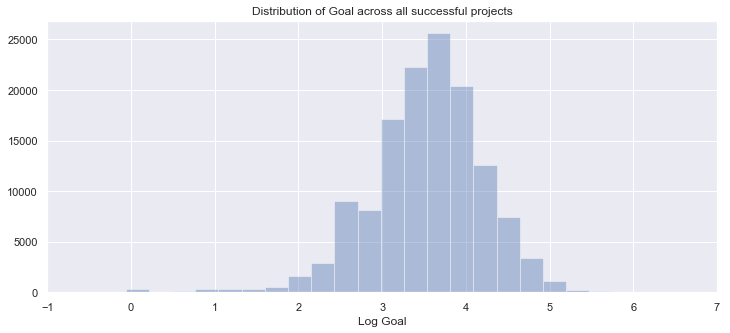

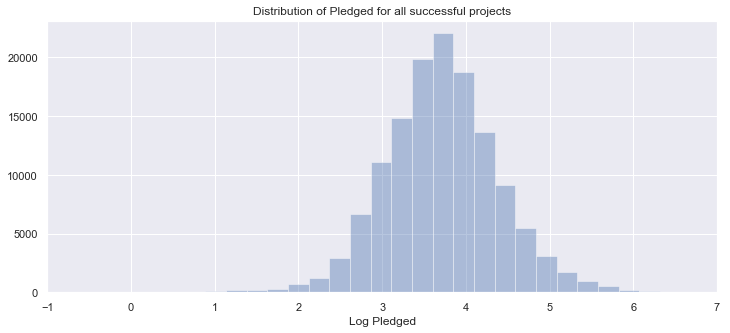

In [10]:
############################################################################################################################
#Distribution of Goal and Pledged amounts across successful projects  - 2 graphs for comparison

temp=data.loc[(data["state"] =='successful')]
fig, ax = plt.subplots(1, 1)

g = sns.distplot(np.log10(temp.usd_goal_real), kde=False, bins=30)
plt.xlim((-1,7))
plt.xlabel('Log Goal')
plt.title('Distribution of Goal across all successful projects')
sns.set(rc={'figure.figsize':(12,5)})
plt.show()


fig, ax = plt.subplots(1, 1)

g = sns.distplot(np.log10(temp.usd_pledged_real), kde=False, bins=30)
plt.xlim((-1,7))
plt.xlabel('Log Pledged')
plt.title('Distribution of Pledged for all successful projects')
sns.set(rc={'figure.figsize':(12,5)})
plt.show()


############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "funding_period_dist"></a>

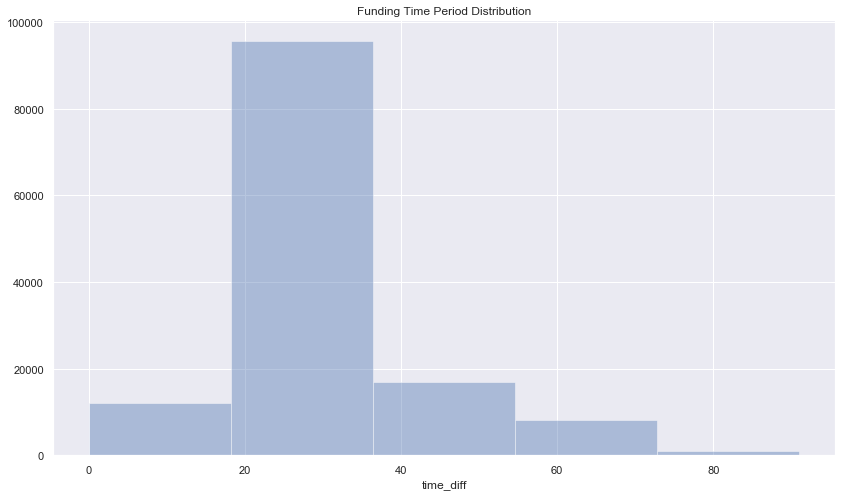

In [119]:
############################################################################################################################
#Funding Time Period Distribution

temp=data.loc[(data["state"] =='successful')]
sns.distplot((temp['time_diff']), kde=False, bins=5)

plt.title('Funding Time Period Distribution')
plt.show()


############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "violin"></a>

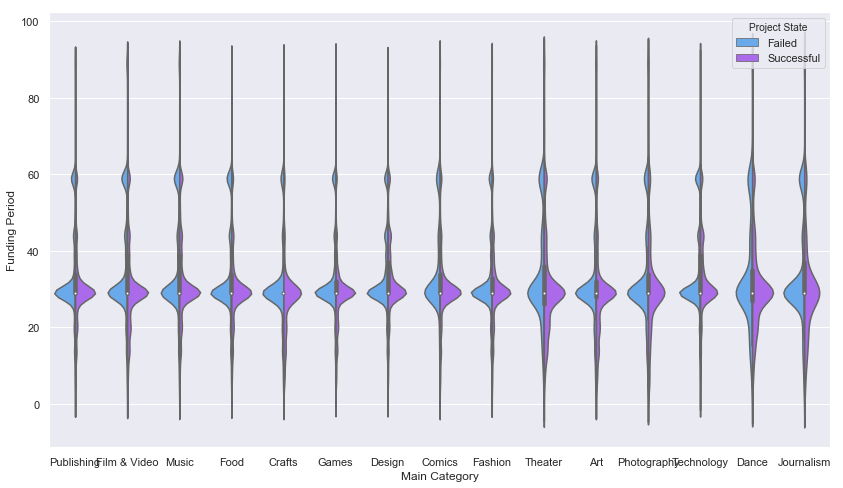

In [35]:
############################################################################################################################
#average funding period for failed and successful projects by category

temp = data.loc[(data["state"] == "successful") | (data["state"] == "failed")]

#group by state and category and count unique projects
#rename columns
temp = temp.rename({"time_diff":"Funding Period"}, axis = 1)
temp = temp.rename({"state":"Project State"}, axis = 1)
temp["Project State"] = temp["Project State"].str.capitalize()
temp = temp.rename({"main_category":"Main Category"}, axis = 1)
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.violinplot(x="Main Category",y="Funding Period",hue="Project State",palette="cool",data=temp,split=True)

############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "wordcloud"></a>

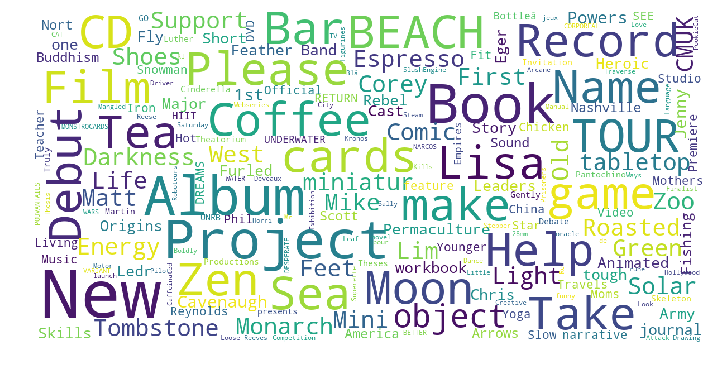

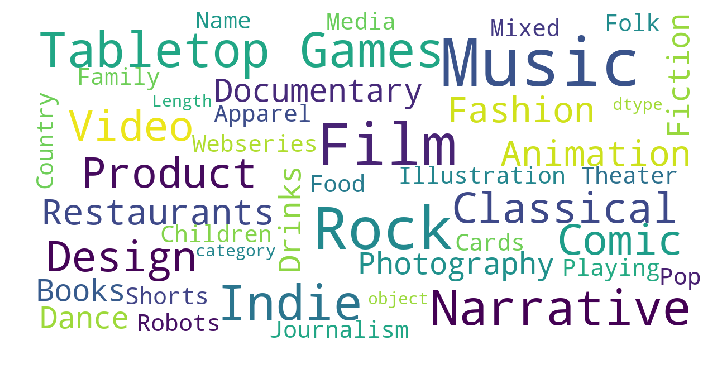

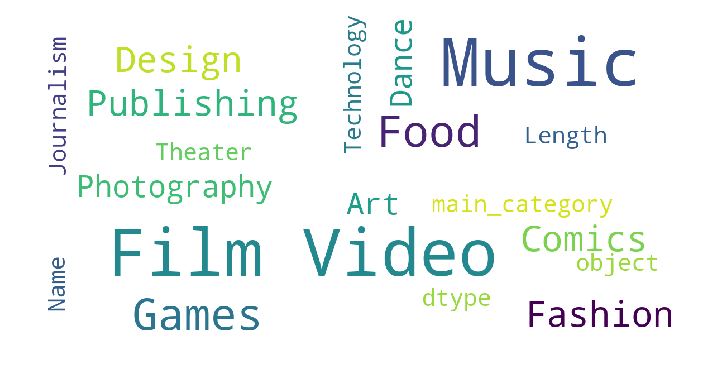

In [4]:
#wordcloud for names of successful projects

temp = data.loc[(data["state"] == "successful")]

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,

        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(temp['name'])
show_wordcloud(temp['category'])
show_wordcloud(temp['main_category'])

<a href = "#top">Back to index</a><br />

<a id = "data_process_model"></a>

In [3]:
############################################################################################################################
#data pre-processing for modeling

data_regression = data.copy()
data_regression = data_regression.loc[data_regression["usd_goal_real"] >= 50]
data_regression = data_regression.loc[data_regression["percent"] <= 10]
#Reach/Willingness calculation
data_regression['willingness']=(data_regression['usd_pledged_real']/data_regression['backers'])/data_regression['usd_goal_real']
data_regression["willingness"].fillna(0, inplace=True)
data_regression.replace(to_replace=[np.inf, -np.inf], value=0, inplace=True)

#considering only successful and failed
data_regression = data_regression.loc[(data_regression["state"] == "successful") | (data_regression["state"] == "failed")]

#converting state to 0 and 1
data_regression['Success'] = np.where(data_regression['state'] == 'successful' ,1,0)

############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "correl_plot"></a>

C:\Users\rukmi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'launched', 'state', 'backers', 'country', 'usd_pledged_real',
       'usd_goal_real', 'Difference', 'percent', 'launch_date', 'launch_time',
       'launch_weekday', 'time_diff', 'willingness', 'Success',
       'log usd_pledged_real', 'log usd_goal_real'],
      dtype='object')
Index(['backers', 'country', 'log usd_pledged_real', 'log usd_goal_real',
       'percent', 'time_diff', 'willingness'],
      dtype='object')
AxesSubplot(0.125,0.125;0.62x0.755)


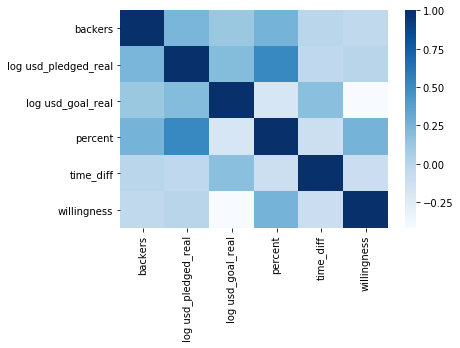

In [4]:
############################################################################################################################
#correlation plot

data_regression['log usd_pledged_real']=np.log10(data_regression['usd_pledged_real'])
#using log for usd_goal_pledged
data_regression['log usd_goal_real']=np.log10(data_regression['usd_goal_real'])

print(data_regression.columns)
data_plot=data_regression.loc[:,['backers', 'country', 'log usd_pledged_real',
       'log usd_goal_real', 'percent','time_diff','willingness']]
print(data_plot.columns) 

print(sns.heatmap(data_plot.corr(), cmap='Blues'))

############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "linear_reg"></a>

coefficient of determination: 0.690678348296891
intercept: [13.53088962]
slope: [[0.01057472]]
THe Linear Model is: Y= [13.53088962]+ [[0.01057472]]X


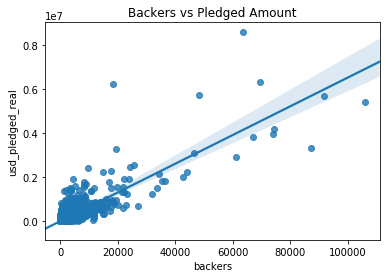

In [5]:
############################################################################################################################
# linear regression b/w backers and pledged amount

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
# values converts it into a numpy array
X = data_regression.loc[:, 'usd_pledged_real'].values.reshape(-1, 1)
# -1 means that calculate the dimension of rows, but have 1 column
Y = data_regression.loc[:, 'backers'].values.reshape(-1, 1)  
linear_regressor = LinearRegression()  # create object for the class
model=linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = model.predict(X)

r_sq = model.score(X, Y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)

print('slope:', model.coef_)

print('The Linear Model is: Y= {}+ {}X'.format(model.intercept_,model.coef_))

sns.regplot(x='backers', y='usd_pledged_real', data=data_regression)
plt.title('Backers vs Pledged Amount')
plt.show()

############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "dummy"></a>

In [31]:
############################################################################################################################
#creating dummies - main category

dummies = pd.get_dummies(data_regression['main_category']).rename(columns=lambda x: 'category_' + str(x))
data_regression = pd.concat([data_regression, dummies], axis=1)

############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "variable_defining"></a>

In [33]:
############################################################################################################################
#defining variables

X = [ 'time_diff','willingness', 'category_Art',
       'category_Comics', 'category_Crafts', 'category_Dance',
       'category_Design', 'category_Fashion', 'category_Film & Video',
       'category_Food', 'category_Games', 'category_Journalism',
       'category_Music', 'category_Photography', 'category_Publishing',
       'category_Technology', 'category_Theater']

Y = ['Success']
     
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
seed = 7
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(data_regression[X], data_regression[Y], test_size=test_size, random_state=seed)

############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "imports"></a>

In [51]:
############################################################################################################################
#imports for modeling

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
from matplotlib import*

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import *
from dtreeviz.trees import *
from IPython.display import Image, display_svg

import nltk
#nltk.download()
import re
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn import datasets, linear_model
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from wordcloud import WordCloud
import ipywidgets as widgets
import pandas_profiling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from scipy.cluster.vq import kmeans, vq , whiten
from sklearn import metrics
from pandas import DataFrame

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.vq import vq, kmeans, whiten
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import scipy as sp
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import ipywidgets as widgets
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans


from copy import deepcopy
from matplotlib import pyplot as plt

import pydotplus
from sklearn.datasets import load_iris
from sklearn import tree
import collections




from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import ipywidgets as widgets

############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "log_reg"></a>

Accuracy: 0.7219344754666095
Precision: 0.7521422588750725
Recall: 0.4494667539367805


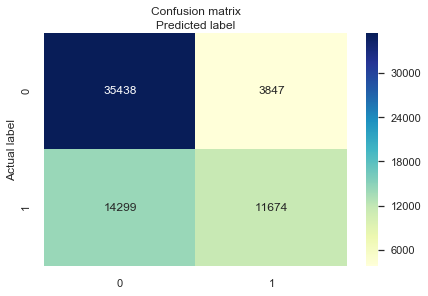

In [52]:
############################################################################################################################
#logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
#X, y = load_iris(return_X_y=True)
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)
predictions = clf.predict(X_test)
#array([0, 0])
clf.predict_proba(X_test) 
#clf.score(predictions, y_test)

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "reg_plot"></a>

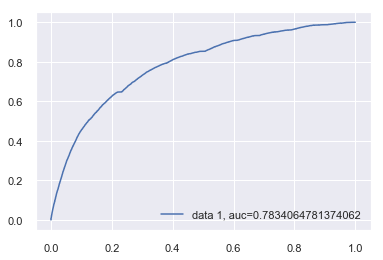

In [53]:
############################################################################################################################
# Regresson plot

y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

############################################################################################################################

<a href = "#top">Back to index</a><br />

<a id = "randomforest"></a>

No handles with labels found to put in legend.


Accuracy: 0.7212142572558153


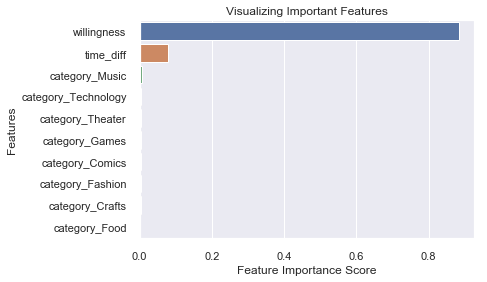

In [54]:
############################################################################################################################
#random forest

clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False).head(10)
#feature_imp = pd.Series(clf.feature_importances_).sort_values(ascending=False)

#features = feature_imp.head(10)


# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

############################################################################################################################

<a href = "#top">Back to index</a><br />